In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import *

import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.style.use('fivethirtyeight')
import random


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from glob import glob
import os
from scipy.signal import resample

today="20220908"


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


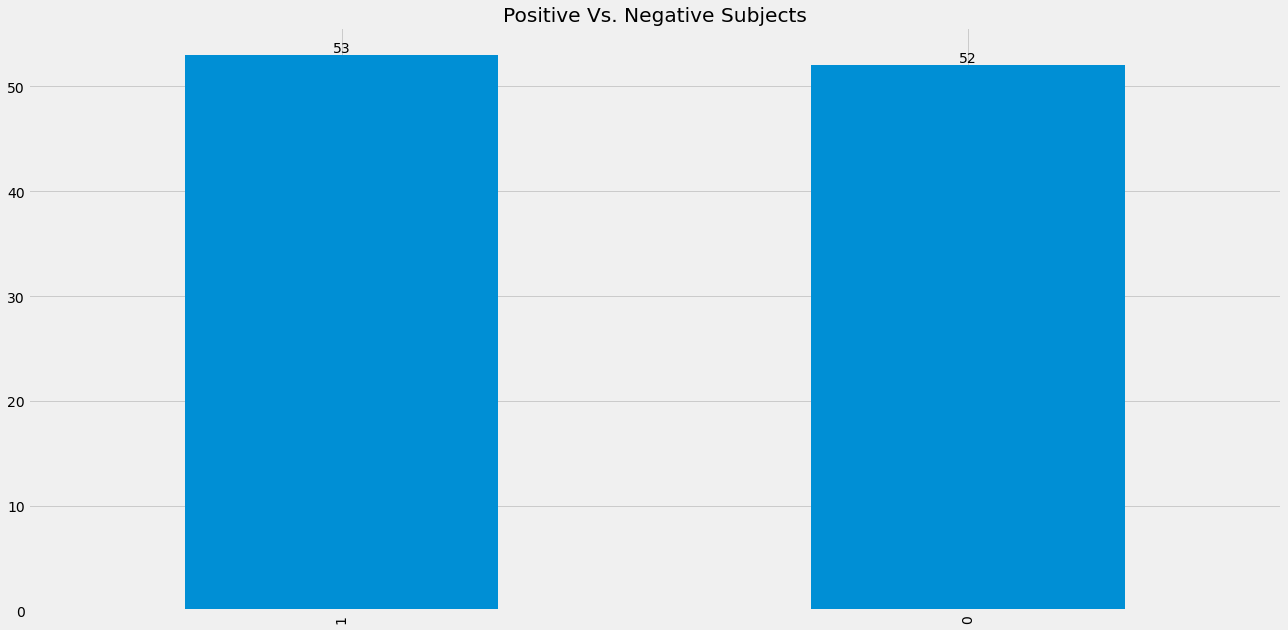

In [3]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)
labels = (levels.Level > 0).astype(np.int16)
ax = labels.value_counts().plot.bar(title='Positive Vs. Negative Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [4]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(today))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(105, 158, 28)

In [5]:
seed=42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.30)

In [6]:
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=4, use_multiprocessing=True, 
                            validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=1)
    return history

## CNN

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [7]:
STEPS_PER_EPOCH = 1
FEATURES = features.shape[1]
CHANNELS = features.shape[2]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.1,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [13]:
tf.random.set_seed(seed) # set up tensorflow seed
tf.keras.backend.clear_session()# avoid impact from previous trainings
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=8, kernel_size=3,
                       activation=tf.nn.relu,
                      input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(filters=4, kernel_size=3,
                           activation=tf.nn.relu),
    tf.keras.layers.LSTM(4, activation=tf.nn.tanh),
    #tf.keras.layers.SimpleRNN(128, activation=tf.nn.tanh),
    #tf.keras.layers.GRU(24, activation=tf.nn.tanh),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [14]:
size_histories = {}
rnn='lstm'

In [15]:
size_histories['cnn/conv1d/'+rnn] = compile_and_fit(cnn, "cnn/conv1d/"+rnn, optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 156, 8)            680       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 4)             100       
                                                                 
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                        

Epoch 46/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5342 - val_loss: 0.7132 - val_accuracy: 0.4375
Epoch 47/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5342 - val_loss: 0.7109 - val_accuracy: 0.4375
Epoch 48/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5342 - val_loss: 0.7105 - val_accuracy: 0.4375
Epoch 49/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.7048 - accuracy: 0.5342 - val_loss: 0.7219 - val_accuracy: 0.4375
Epoch 50/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5342 - val_loss: 0.7051 - val_accuracy: 0.4375
Epoch 51/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5342 - val_loss: 0.6986 - val_accuracy: 0.4375
Epoch 52/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5342 - val_loss: 0.7050 - val_accuracy: 0.4375

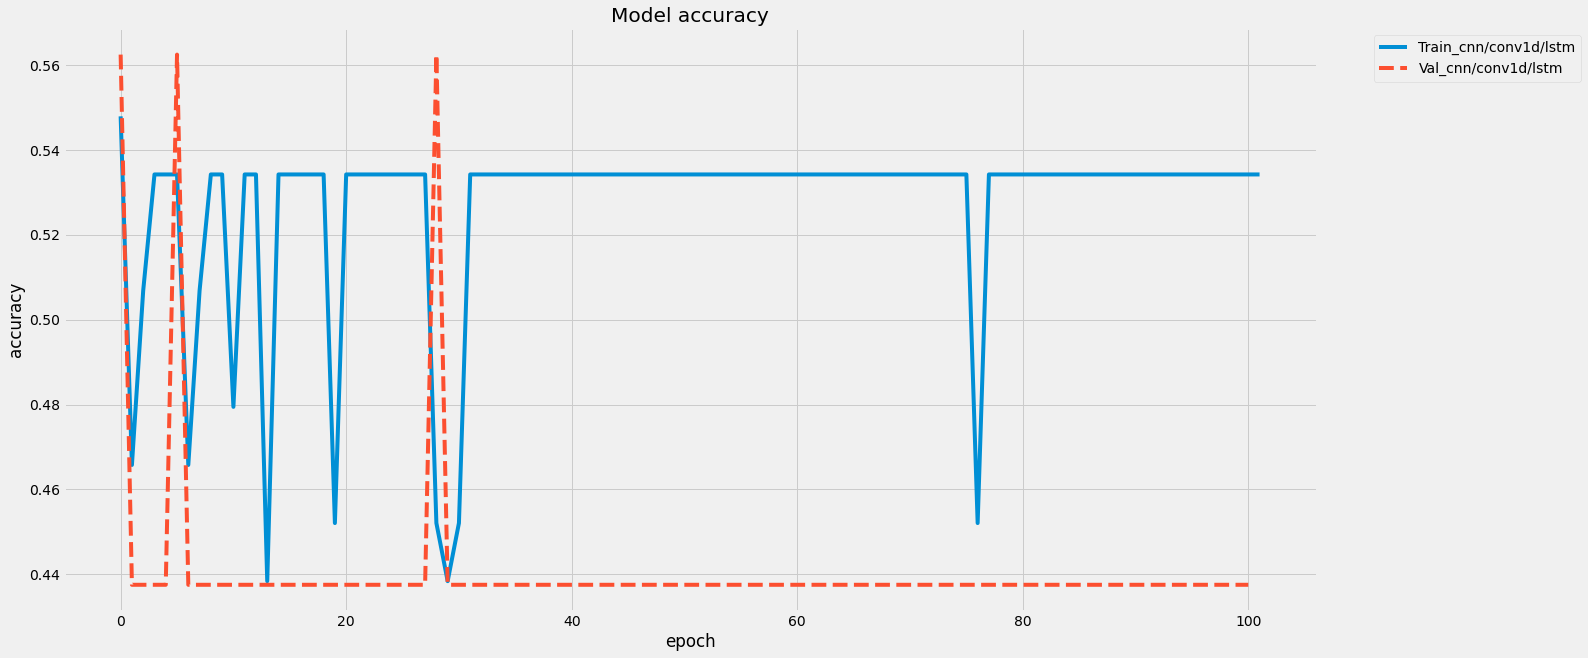

In [16]:
plot_report(size_histories, metric='accuracy')

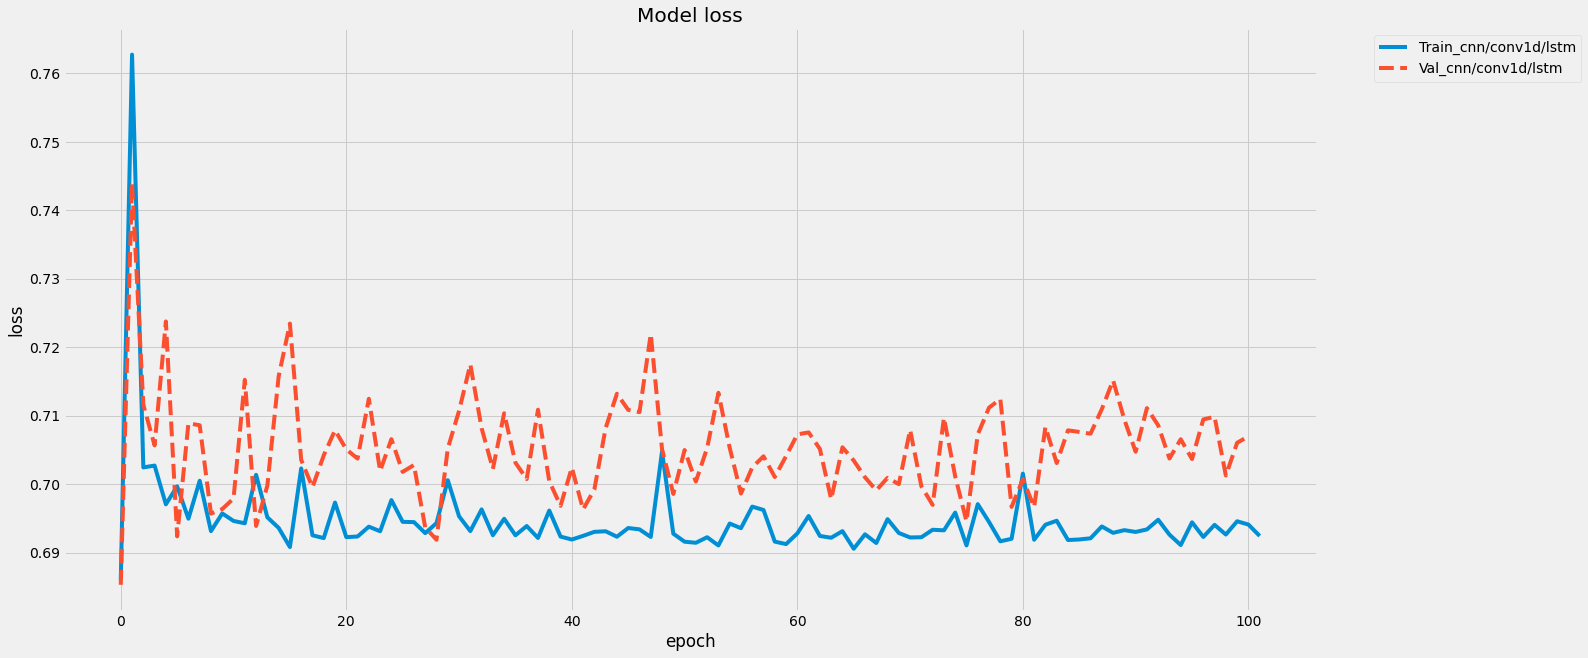

In [17]:
plot_report(size_histories, metric='loss')